In [1]:
using Plots; pyplot()
using Distributions;
using AugmentedGaussianProcesses
using KernelFunctions;

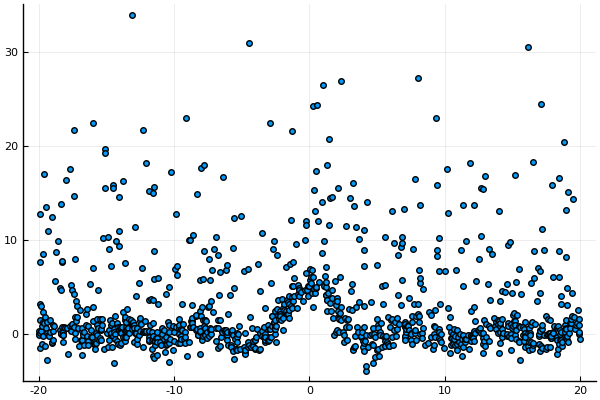

In [2]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
outliers = rand(N).>0.7
Y = (latent(X)+(1.0.-outliers).*rand(Normal(0,1),N)+abs.(outliers.*rand(Normal(0,10),N))[:]);
scatter(X,Y,lab="")

In [3]:
# Run sparse classification with increasing number of inducing points
Ms = [4, 8, 16, 32, 64]
models = Vector{AbstractGP}(undef,length(Ms)+1)
# Create a kernel from KernelFunctions.jl
kernel = SqExponentialKernel(1.0)
ν=10.0
for (index, num_inducing) in enumerate(Ms)
    @info "Training with $(num_inducing) points"
    m =  SVGP(X, vec(Y), kernel, StudentTLikelihood(ν), AnalyticVI(), num_inducing)
    @time train!(m,100)
    models[index] = m;
end

┌ Info: Training with 4 points
└ @ Main In[3]:8


 11.391404 seconds (43.92 M allocations: 2.286 GiB, 8.82% gc time)


┌ Info: Training with 8 points
└ @ Main In[3]:8


  0.121382 seconds (1.02 M allocations: 230.657 MiB, 29.23% gc time)


┌ Info: Training with 16 points
└ @ Main In[3]:8


  0.200859 seconds (1.03 M allocations: 372.549 MiB, 24.40% gc time)


┌ Info: Training with 32 points
└ @ Main In[3]:8


  0.362029 seconds (1.03 M allocations: 664.635 MiB, 20.80% gc time)


┌ Info: Training with 64 points
└ @ Main In[3]:8


  0.768050 seconds (1.04 M allocations: 1.252 GiB, 16.46% gc time)


In [4]:
@info "Training with full model"
mfull = VGP(X, vec(Y), kernel, StudentTLikelihood(ν), AnalyticVI())
@time train!(mfull,5);
models[end] = mfull;

┌ Info: Training with full model
└ @ Main In[4]:1


  2.807392 seconds (6.47 M allocations: 892.595 MiB, 13.15% gc time)


In [5]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
#     Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y,sig_y = proba_y(model,Xplot)
    return (y,sig_y,Xplot)
end

compute_Grid (generic function with 2 methods)

In [11]:
function plotdata(X,Y)
    Plots.plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500))
    end;

In [12]:
function plotcontour(model,X,Y)
    nGrid = 100
    y,sig_y,x = compute_Grid(model,nGrid)
    p = plotdata(X,Y)
    plot!(p,x,y,ribbon=2*sqrt.(sig_y),title=( model isa SVGP ? "M = $(model.nFeatures)" : "full"),color="red",lab="",linewidth=3.0)
    if model isa SVGP
        plot!(p,model.f[1].Z[:,1],zero(model.f[1].Z[:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return p
    end;

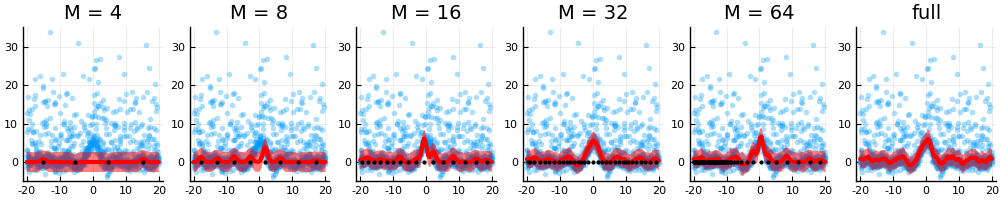

In [13]:
Plots.plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))